In [5]:
from river import datasets
from river import drift
import numpy as np

import matplotlib.pyplot as plt

In [21]:
ds1 = np.random.normal(0, 1, 1000)
ds2 = np.random.normal(1, 3, 1000)
ds3 = np.random.normal(5, 1, 1000)
ds4 = np.random.normal(0, 2, 1000)
ds5 = np.random.normal(0, 2, 1000)
data_stream = np.concatenate((ds1, ds2, ds3, ds4, ds5), axis=0)

In [22]:
klwin = drift.JSWIN(alpha=0.5, seed=42)
tres = []
drift_idx = []

for i, val in enumerate(data_stream):
    klwin.update(val)
    tres.append(klwin._js_value)
    if klwin.drift_detected:
        print(f"Change detected at index {i}, input value: {val}")
        drift_idx.append(i)

Change detected at index 813, input value: 0.16685528089355775
Change detected at index 2025, input value: 3.5864590689532587
Change detected at index 2251, input value: 5.823240434901927
Change detected at index 3045, input value: 3.1941088670420363
Change detected at index 3845, input value: 0.0347841022316795
Change detected at index 4429, input value: 0.5375023307726791
Change detected at index 4682, input value: 1.1964690188737876


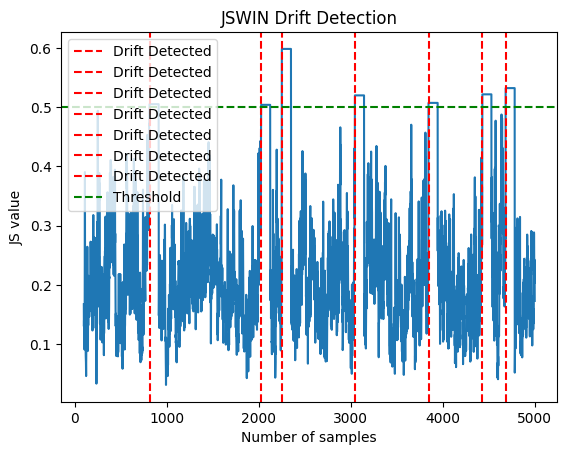

In [23]:
plt.plot(tres)
plt.title('JSWIN Drift Detection')
plt.xlabel('Number of samples')
plt.ylabel('JS value')
for i in drift_idx:
    plt.axvline(x=i, color='r', linestyle='--', label='Drift Detected')
plt.axhline(y=klwin.alpha, color='g', linestyle='--', label='Threshold')
plt.legend()
plt.show()

In [25]:
kswin = drift.KSWIN(alpha=0.001, seed=42)

for i, val in enumerate(data_stream):
    kswin.update(val)
    if kswin.drift_detected:
        print(f"Change detected at index {i}, input value: {val}")

Change detected at index 380, input value: -0.3824138140005066
Change detected at index 1032, input value: 6.008191943319606
Change detected at index 1568, input value: -3.9444358245902995
Change detected at index 2016, input value: 3.2720880284888816
Change detected at index 3012, input value: -2.994657468816773
